<a href="https://colab.research.google.com/github/cyberfenrir/Neural-Style-Transfer/blob/main/DL_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning with PyTorch : Neural Style Transfer


## Task 1 : Set Google Colab runtime

In [1]:
!pip install torch torchvision

In [2]:
!git clone https://github.com/cyberfenrir/Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 5), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (20/20), done.


## Task 2 : Loading VGG Pretrained Model

In [3]:
import torch
from torchvision import models

#loading vgg19 pretrained model
vgg = models.vgg19(pretrained= True)

#print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
#excluding classifiers part as we will be extracting styles from the features.

vgg_features = vgg.features
print(vgg_features)

#vgg_classifiers = vgg.classifier 
#print(vgg_classifiers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
#freezing the vgg layers so that no updatation of weights/gradient computation and such occurs.
for parameters in vgg.parameters():
  
  parameters.requires_grad_(False)

In [6]:
#moving variables and models to gpu using cuda.

device = torch.device("cuda" if torch.cuda.is_available()else "cpu")
print(device)

cuda


In [7]:
vgg_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [8]:
from PIL import Image
from torchvision import transforms as T

#function to pass image and resize it.

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size)> max_size:
    size = max_size
  
  else:
    size = max(image.size)

  img_transform = T.Compose([
              T.Resize(size),
              T.ToTensor(),
              T.Normalize(mean =[0.485, 0.456, 0.406],
                          std = [0.229, 0.224, 0.225])             
  ])
  image = img_transform(image)

  image = image.unsqueeze(0) #(3, 224, 224) -> (1, 3, 224, 224)
  return image

<h1>In the previous code cell:

<h3>Why I used those specific mean and standard daviation values for normalization:


all pre trained models expect 
                                        input images normalised in the same way
                                        i.e, mini batches of 3 channel RGB image 
                                        of a shape(3 x H x W) where H and W are 
                                        expected to be at least 224. the images 
                                        are loaded in to a range of [0,1] and then 
                                        normalized usng mean = [0.485, 0.456, 0.406]
                                        and std = [0.229, 0.224, 0.225]

<h3> What did Unsqueeze method do to my tensor:

suppose if my tensor/image is of the form (3,224,224)
                         of the format (channel, height, width) then what this does
                         is basically add a batch number(1) to the form. 
                         result will be something like (1, 3, 224, 224).

In [10]:
content_p = preprocess('/content/Neural-Style-Transfer/image.jpeg')
style_p = preprocess('/content/Neural-Style-Transfer/style image.jpeg')
content_p = content_p.to(device)
style_p = style_p.to(device)

print('content shape: ', content_p.shape)
print('style shape: ', style_p.shape)



content shape:  torch.Size([1, 3, 666, 500])
style shape:  torch.Size([1, 3, 500, 631])


## Task 4 : Deprocess image

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                 #denormalize
  image = image.clip(0,1)
  
  return image

In [12]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print('deprocessed content:', content_d.shape)
print('deprocessed style: ', style_d.shape)


deprocessed content: (666, 500, 3)
deprocessed style:  (500, 631, 3)


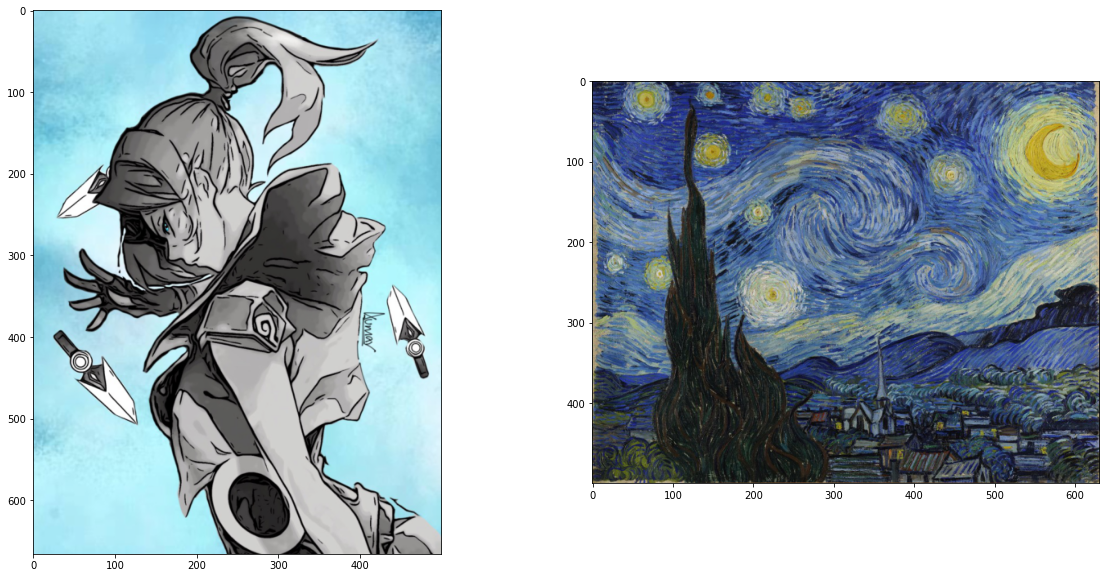

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,10))

ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

In [14]:
def get_features(image, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',   #content_feature
      '28': 'conv5_1'
  }

  x= image

  features={}

  for name, layer in model._modules.items():

    x=layer(x)
    if name in layers:
      features[layers[name]] = x
    
  return features


In [15]:
content_f = get_features(content_p, vgg_features)
style_f = get_features(style_p, vgg_features)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<h2>GRAM MATRIX

suppose my tensor is in the shape of a cube with channels as its z axis height as its y axis and width as its x axis. 
the unrolled function looks like channel, height * width.matrix multiplication is done with the unrolled version of the tensor and its transpose. the resultiong matrix is the gram matrix.


In [16]:
def gram_matrix(tensor):

  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram


In [17]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}


 Creating Style and Content loss function

In [18]:
def content_loss(target_conv4_2,content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [19]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [20]:
def style_loss(style_weights, target_features,style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)
  return loss


In [21]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg_features)
print("content loss: " , content_loss(target_f['conv4_2'], content_f['conv4_2']))
print("style loss: " , style_loss(style_weights, target_f, style_grams))



content loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
style loss:  tensor(804.9497, device='cuda:0', grad_fn=<AddBackward0>)


## Task 7 : Training loop

In [22]:
from torch import optim


optimizer = optim.Adam([target], lr = 0.03)   #learning rate at 3%

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500


In [23]:
def total_loss(c_loss,s_loss, alpha, beta):

  loss = alpha* c_loss + beta * s_loss
  return loss
  

In [24]:
results = []

for i in range(epochs):

  target_f = get_features(target, vgg_features)

  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)
  
  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print("Total loss at epoch {} : {}".format(i,t_loss))
    results.append(deprocess(target.detach()))


Total loss at epoch 0 : 80494968.0
Total loss at epoch 500 : 327499.3125
Total loss at epoch 1000 : 124212.9140625
Total loss at epoch 1500 : 64008.04296875
Total loss at epoch 2000 : 36411.765625
Total loss at epoch 2500 : 24307.572265625


<function matplotlib.pyplot.show>

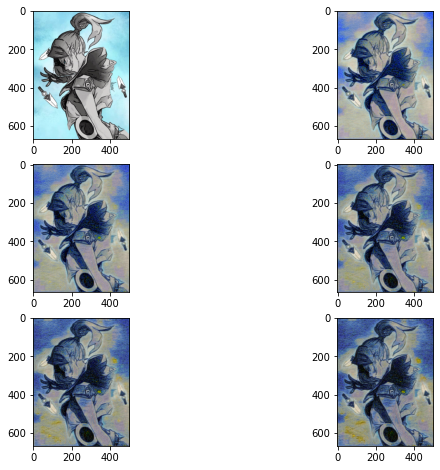

In [25]:
plt.figure(figsize = (10,8))

for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])

plt.show


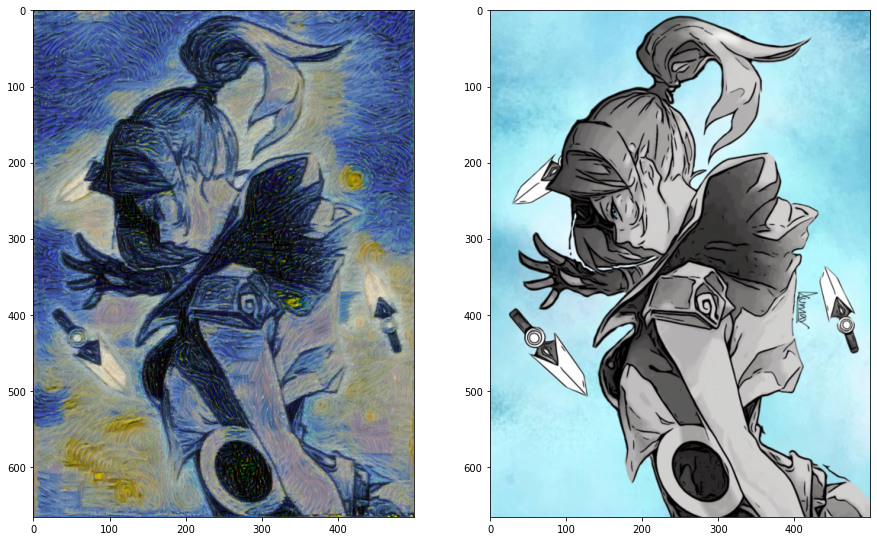

In [26]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig,(ax1,ax2) = plt.subplots(1,2, figsize = (15,10))
ax1.imshow(target_copy)
ax2.imshow(content_copy)
